In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# import train.csv file
path = '/content/drive/MyDrive/data'
data = pd.read_csv(path + "/train.csv")
data.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [28]:
# check shape of data
data.shape

(10407, 4)

In [29]:
# check unique values
data['label'].unique().tolist()

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [30]:
data['variety'].unique().tolist()

['ADT45',
 'IR20',
 'KarnatakaPonni',
 'Onthanel',
 'Ponni',
 'Surya',
 'Zonal',
 'AndraPonni',
 'AtchayaPonni',
 'RR']

In [31]:
data['age'].describe()

count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Variety Distribution')

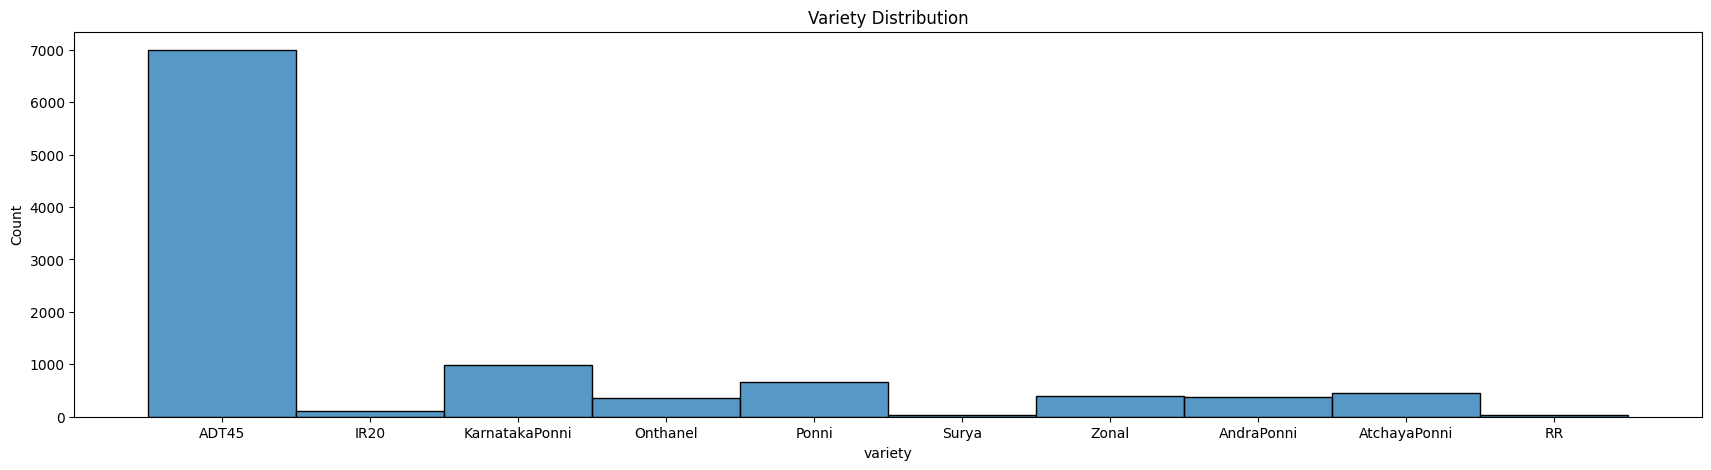

In [32]:
#plot data count based on variety name
plt.figure(figsize=(21, 5))
sns.histplot(data,x='variety')
plt.title('Variety Distribution')

In [33]:
normal = data[(data['label'] == 'normal') & (data['variety'] == 'ADT45')].image_id[:5].values
dead = data[(data['label'] == 'dead_heart') & (data['variety'] == 'ADT45')].image_id[:5].values

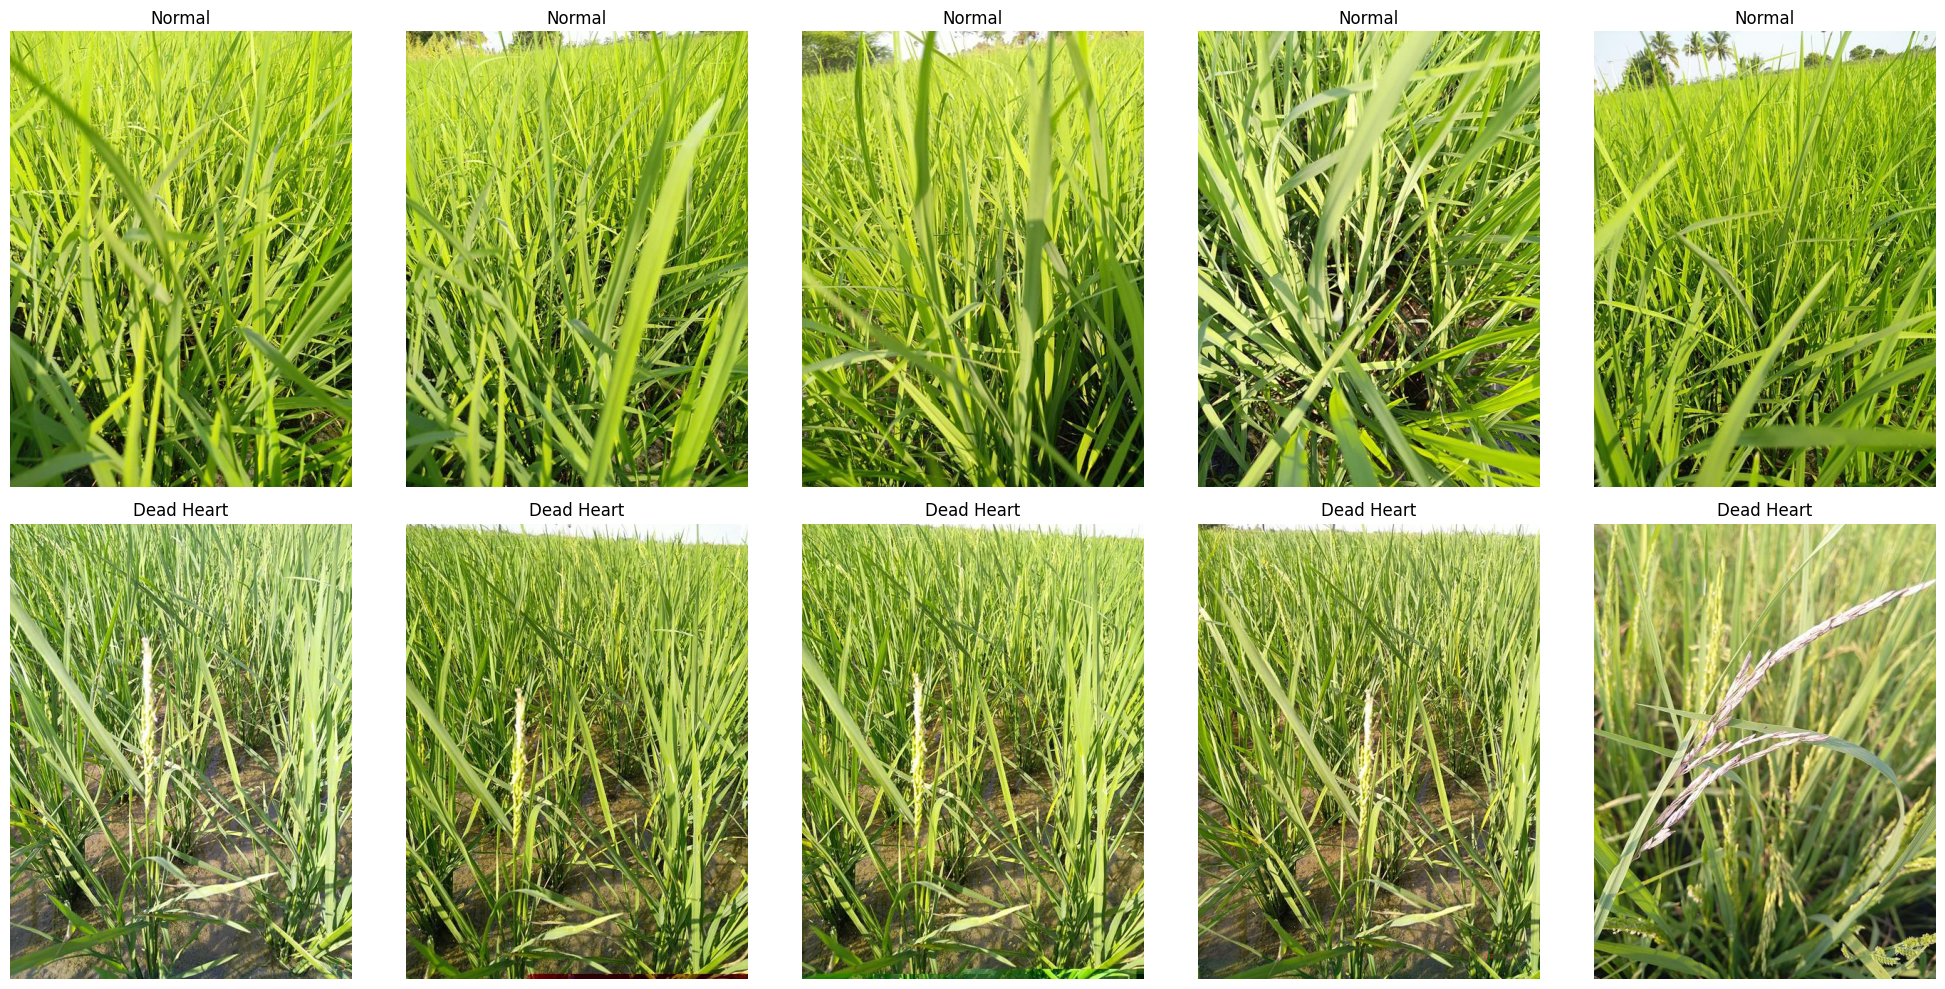

In [ ]:
plt.figure(figsize=(20, 10))

image_path = os.path.join(path, 'train_images')
for i, img_id in enumerate(np.concatenate([normal, dead])):
    folder = 'normal' if i < 5 else 'dead_heart'
    img_path = os.path.join(image_path, folder, img_id)

    if os.path.exists(img_path):
        plt.subplot(2, 5, i + 1)
        plt.imshow(plt.imread(img_path))
        plt.title("Normal" if i < 5 else "Dead Heart")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()


## Observations:
1. we have 10407 images in train data
2. 10 unique clasees in data
3. 10 unique variety of rice in data
4. Age of rice plant ranges from 45-82, 64 days on average
5. ADT-45 is most common variety

In [34]:
# encode categorcal columns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['variety'] = le.fit_transform(data['variety'])
data['label'] = le.fit_transform(data['label'])

In [35]:
data.head()

image_id  label  variety  age
0  100330.jpg      0        0   45
1  100365.jpg      0        0   45
2  100382.jpg      0        0   45
3  100632.jpg      0        0   45
4  101918.jpg      0        0   45

In [36]:
import tensorflow as tf

In [37]:
# define parameters
batch_size = 16
img_height = 128
img_width = 128
AUTOTUNE = tf.data.AUTOTUNE
image_dir = os.path.join(path, 'train_images')

In [38]:
print("Path exists:", os.path.exists(image_dir))
print("Contents:", os.listdir(image_dir))


Path exists: True
Contents: ['downy_mildew', 'blast', 'hispa', 'bacterial_leaf_streak', 'brown_spot', 'bacterial_leaf_blight', 'tungro', 'dead_heart', 'normal', 'bacterial_panicle_blight']


In [39]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10343 files belonging to 10 classes.
Using 8275 files for training.


In [40]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10343 files belonging to 10 classes.
Using 2068 files for validation.


In [41]:
class_names = train_ds.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [42]:
normalize_layer = tf.keras.layers.Rescaling(1./255)

In [43]:
train_ds = train_ds.map(lambda x, y: (normalize_layer(x), y)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalize_layer(x), y)).cache().prefetch(AUTOTUNE)

In [44]:
num_classes = len(class_names)
num_classes

10

In [45]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
early_stopping = EarlyStopping(patience=10)

In [ ]:
history= model.fit(train_ds,
          validation_data=val_ds,
          epochs=100,
          callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


315/518 ━━━━━━━━━━━━━━━━━━━━ 6:36 2s/step - accuracy: 0.1728 - loss: 2.1934

In [ ]:
loss = model.evaluate(val_ds)

In [ ]:
# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()